In [1]:
DATASET = 'STL10' # choose dataset (CIFAR10, CIFAR100-20, or STL10)

In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), # load data as pytorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize/scale the images
])

# each set is loaded a bit differently
def load(dataset):
    if dataset == 'CIFAR10':
        trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
        testset  = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)
        return trainset, testset
    elif dataset == 'CIFAR100-20':
        trainset = datasets.CIFAR100(root='./data/cifar100', train=True, download=True, transform=transform)
        testset  = datasets.CIFAR100(root='./data/cifar100', train=False, download=True, transform=transform)
        return trainset, testset
    elif dataset == 'STL10':
        # note the use of split='train' here instead of train=True
        trainset = datasets.STL10(root='./data/stl10', split='train', download=True, transform=transform)
        testset  = datasets.STL10(root='./data/stl10', split='test', download=True, transform=transform)
        return trainset, testset

trainset, testset = load(DATASET)
classes = trainset.classes # grab an array of classnames

# wrap in a dataloader -- for use in the CNN
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


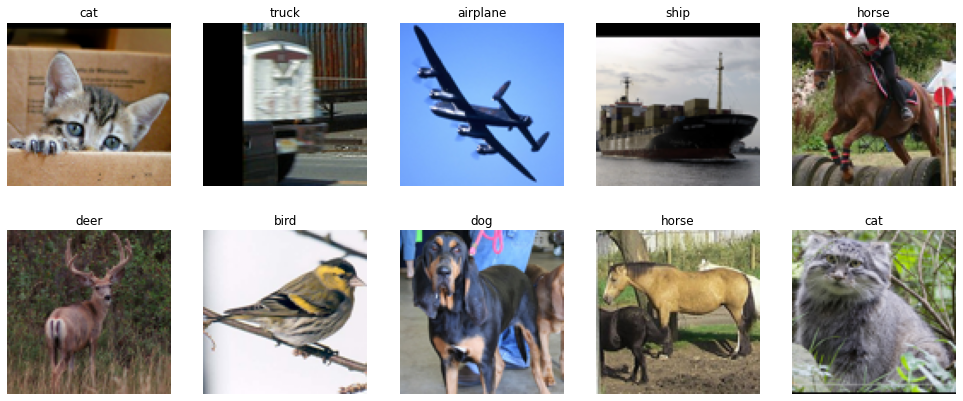

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# quick function to un-normalize and transpose images before graphing
def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

figure = plt.figure(figsize=(17, 7))
for i in range(1, 11):
    figure.add_subplot(2, 5, i)
    image, label = next(iter(trainloader))
    plt.title(classes[label[0].item()])
    plt.axis("off")
    img = image[0].squeeze()
    label = label[0]
    imshow(make_grid(img))
plt.show()

In [6]:
# determine train test split and k values based on dataset
def prep(dataset):
    if dataset == 'STL10':
        X_train = np.array(trainloader.dataset.data).reshape(5000, 27648)
        y_train = np.array(trainloader.dataset.labels)
        X_test  = np.array(testloader.dataset.data).reshape(8000, 27648)
        y_test  = np.array(testloader.dataset.labels)
    else:
        X_train = np.array(trainloader.dataset.data).reshape(50000, 3072)
        y_train = np.array(trainloader.dataset.targets)
        X_test  = np.array(testloader.dataset.data).reshape(10000, 3072)
        y_test  = np.array(testloader.dataset.targets) 
    
    kvals = [80, 90, 95, 100, 105, 120] if dataset == 'CIFAR100-20' else [2, 5, 10, 12, 15, 20]
    
    return X_train, y_train, X_test, y_test, kvals

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import normalized_mutual_info_score

error, scores = [], []
headers = ["k value", "ARI", "NMI", "ACC"]
X_train, y_train, X_test, y_test, kvals = prep(DATASET)

# find predicted values and calculate some scores
for k in kvals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append([
        k,
        accuracy_score(y_test, y_pred),
        normalized_mutual_info_score(y_test, y_pred),
        adjusted_rand_score(y_test, y_pred)
    ])

scores = np.array(scores)
data = pd.DataFrame(scores, columns=headers)
data

,k value,ARI,NMI,ACC
0,2.0,0.263625,0.142144,0.080586
1,5.0,0.276125,0.159064,0.094941
2,10.0,0.270625,0.162539,0.092261
3,12.0,0.269250,0.165499,0.091624
4,15.0,0.268125,0.168391,0.090171
5,20.0,0.270750,0.173631,0.089746
